# Error Analyses

In [2]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import quail
import pickle
import scipy
import scipy.stats
from scipy.stats import pearsonr
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from itertools import groupby
from collections import OrderedDict

/Users/campbellfield/anaconda/lib/python2.7/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Load Data

In [3]:
man = quail.load_egg('../data/man_egg.egg')
auto = quail.load_egg('../data/auto_egg.egg')

In [33]:
man_errs = {'external': [], 'intrusion': [], 'num recalled': []}
auto_errs = {'external': [], 'intrusion': [], 'num recalled': []}

for trans,dic in zip([man,auto], [man_errs, auto_errs]):
# for each transcription type
    
    for sub in range(len(auto.meta['ids'])):
    # for each subject 
    
        all_presented = []
        external = []
        intrusion = [0]*8
        num_recalled = []
        
        for lst in range(0,8):
        # for each list
        
            ext_count = 0
            
            # load presented and recalled words
            recalled = [x for x in trans.rec.loc[sub].loc[lst].values if type(x)==str] 
            num_recalled.append(len(recalled))
            presented = trans.pres.loc[sub].loc[lst].values
            
            # select recalls not matching words presented on this trial
            extras = set(recalled).difference(set(presented))
            
            # if extra word prev presented, add to correct intrusion list
            for word in extras:
                for idx,sublist in enumerate(all_presented):
                    if word in sublist:
                        intrusion[lst-idx]+=1.0
                        
                # else, add to ext_count        
                else:
                    ext_count += 1
            
            # append proportion of recalls that are external errors
            external.append(ext_count/float(len(recalled)))
    
            all_presented.append(presented)
        
        dic['external'].append(np.mean(external))
        dic['intrusion'].append(intrusion)  
        dic['num recalled'].append(sum(num_recalled))

(0.62711664045260784, 0.00020839466975176217)


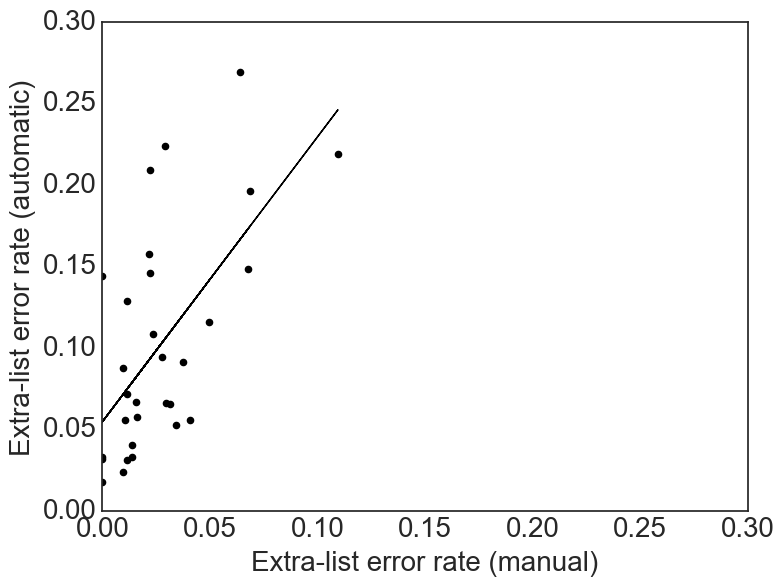

In [34]:
#plot average proportion of external errors in man vs. auto transcription on scatter plot
sns.set_style('white')
fig, ax = plt.subplots()
plt.scatter(man_errs['external'], auto_errs['external'], color = 'black', edgecolors = 'black')

#label axes
ax.set_xlabel('Extra-list error rate (manual)', size = 20)
ax.set_ylabel('Extra-list error rate (automatic)', size = 20)
plt.tick_params(labelsize=20)
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)

#get line of best fit
reg_line = np.polyfit(man_errs['external'], auto_errs['external'], 1)
reg_line_fn = np.poly1d(reg_line)
plt.plot(man_errs['external'], reg_line_fn(man_errs['external']), color = 'black')

#get R value
r = pearsonr(man_errs['external'], auto_errs['external'])
# plt.text(0.14, 0.15, '$r = 0.61$', size = 20)
# plt.text(0.14, 0.12, '$p < 0.0003$', size = 20)
print r

#save plot and show
plt.tight_layout()
plt.style.use('default')
plt.show()

In [35]:
# make list-back plots here using the 'intrusion' dict keys
print man_errs['intrusion'][29]
#['intrusion'][sub][listnum] gives you number of errors 
#from listnum lists back
print man_errs['num recalled'][29]
#['num recalled'][sub] gives you total words recalled for that sub

[0, 2.0, 1.0, 1.0, 0, 0, 0, 0]
97


In [36]:
#we want to get the proportion of words recalled that were previous list errors
#one list back plot will have one point for each subject:
#-proportion of words recalled that were one-back errors for auto
#-same proportion for man

#out of all the words recalled for that subject, how many are one-back errors etc.?
for trans in [man_errs, auto_errs]:
    #for each transcription type
    
    trans['avg intrusion errors'] = {
        '1back': [], 
        '2back': [],
        '3back': [],
        '4back': [],
        '5back': [],
    }

    for sub in range(len(auto.meta['ids'])):
    #for each subject
        
        for list_back in range(1, 6):
        #for each list back
        
            #get proportion of list back errors for each subject
            prop = trans['intrusion'][sub][list_back] / trans['num recalled'][sub]
            trans['avg intrusion errors']['%sback' % list_back].append(prop)    

[0.006423330702096119, 0.002944947246525069, 0.0012855994939392386, 0, 0.00046948356807511736]
[0.00595455124001568, 0.0024991460259317405, 0.0013043091168091169, 0, 0.0010988284775258954]


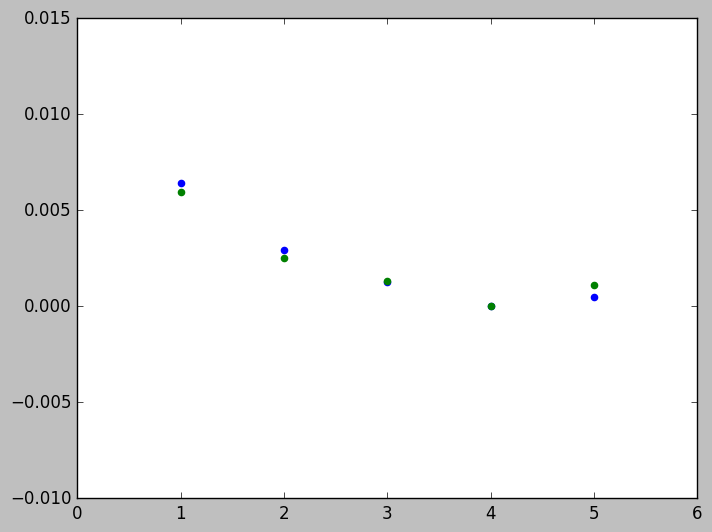

In [51]:
for trans in [man_errs, auto_errs]:
    

    trans['avg intrusion errors per list back'] = []
    for list_back in range(1, 6):
        trans['avg intrusion errors per list back'].append(sum(trans['avg intrusion errors']['%sback' % list_back])/30)
    print trans['avg intrusion errors per list back']
plt.scatter(range(1,6), man_errs['avg intrusion errors per list back'], color = 'blue')
plt.scatter(range(1,6), auto_errs['avg intrusion errors per list back'], color = 'green')
ax.set_xlim(0, 5)
ax.set_ylim(0, 1)
ax.set_xticks([1,2,3,4,5])
plt.show()

# Troublehsoot

You can see in the cells below that subjects at the indices 7, 10, 19, and 27 have different values in my and campbell's computations. (All four subs have different values for auto, for the man campbell and i are mismatched only for subject 27)

Can you look over the calculations for extermal errors in both notebooks for these subjects and see where the difference comes in?


In [8]:
camp_auto=  [0.024305555555555552,
0.05803571428571428,
0.03314393939393939,
0.06558441558441559,
0.1966765873015873,
0.017857142857142856,
0.2239801864801865,
0.15774941969794912,
0.09456699346405228,
0.05625,
0.13820346320346322,
0.07233183483183483,
0.10903679653679654,
0.05587121212121212,
0.15793403900021546,
0.14423076923076922,
0.06625457875457876,
0.03314393939393939,
0.03139568764568765,
0.225,
0.09172979797979798,
0.06697330447330446,
0.11634615384615385,
0.040972222222222215,
0.14891774891774892,
0.032196969696969696,
0.05323374542124542,
0.0969030969030969,
0.21960470085470088,
0.26975888694638694]

camp_man = [0.009615384615384616,
0.016281512605042014,
0.013888888888888888,
0.03165584415584416,
0.0686431623931624,
0.0,
0.028960622710622712,
0.022115384615384617,
0.027777777777777776,
0.040625,
0.011363636363636364,
0.011363636363636364,
0.023504273504273504,
0.010416666666666666,
0.021780303030303032,
0.0,
0.029761904761904764,
0.0,
0.011363636363636364,
0.02222222222222222,
0.037500000000000006,
0.015625,
0.04979395604395605,
0.013888888888888888,
0.06766774891774892,
0.0,
0.03400297619047619,
0.019230769230769232,
0.10952380952380952,
0.06392773892773893]

In [9]:
camp_man == man_errs['external']

False

In [10]:
type(camp_auto)

list

In [11]:
for idx,x in enumerate(camp_auto):
    if x != auto_errs['external'][idx]:
        print(idx)
        print(x,auto_errs['external'][idx]) 
        print

7
(0.15774941969794912, 0.14638578333431276)

10
(0.13820346320346322, 0.12927489177489176)

19
(0.225, 0.20937500000000001)

27
(0.0969030969030969, 0.087974525474525472)



In [12]:
for idx,x in enumerate(man_errs['external']):
    if x != camp_man[idx]:
        print(idx)
        print(camp_auto[idx], x)
        print

27
(0.0969030969030969, 0.0096153846153846159)

